# FEniCS simulation of a cantilever beam

The aim of this notebook is to setup a very simple FEniCS simulation. The framework is linear, plane strain elasticity. We model a cantilever beam ($L$: total length; $d$: depth), subjected to its own weight ($\rho$: mass density per unit volume; $g$: gravity).

The beam is homogenous and isotropic ($E$: Young modulus; $\nu$: Poisson ratio) and clamped on the left end. Hooke's law reads

\begin{equation}
\sigma_{ij} = \lambda\varepsilon_{kk}\delta_{ij}+2\mu\varepsilon_{ij},
\end{equation}

where indices $i, j, k$ are restricted to $\{1, 2\}$ and $\lambda$, $\mu$ are the Lamé coefficients :

\begin{equation*}
\mu=\frac{E}{2\bigl(1+\nu\bigr)}
\quad\text{and}\quad
\lambda=\frac{2\mu\nu}{1-2\nu}.
\end{equation*}

**Question:** how does Hooke's law read in *plane stress* elasticity?

The variational formulation of the problem is the following:

Find $u\in \mathcal{C}\equiv\{u: H^1(\Omega), \; u(x_1=0,x_2)=0\}$ such that 
$\forall v\in \mathcal{C}_0\equiv \mathcal{C}$


\begin{equation}
\int_\Omega \sigma(\varepsilon(u)):\varepsilon(v)\,\mathrm{d}x\,\mathrm{d}y =
-\int_{\Omega}\rho g\,e_y\cdot v\,\mathrm{d} x\,\mathrm{d} y,
\end{equation}

where $\sigma(\varepsilon)$ is the constitutive equation and $\varepsilon(u)=\mathrm{sym} (\nabla u)$  

Remark: we work with only one unknown vector field, the displacement $\{u_x(x_1,x_2),u_y(x_1,x_2)\}$

![image of beam](cantilever_beam.png "Cantilever beam")

In [1]:
import dolfinx # FEM in python
import matplotlib.pyplot as plt
import ufl # variational formulations
import numpy as np
#from mpi4py import MPI
import mpi4py
from petsc4py.PETSc import ScalarType

This tutorial

https://jorgensd.github.io/dolfinx-tutorial/chapter2/linearelasticity_code.html

is in 3D. Please adapt it in the present 2D case.

## 1) Start with defining the mesh

In [2]:
# geometry and mesh 
L = 1. # total length
d = L/10. # thickness
h = d/6. # size of a cell

use 
```
dolfinx.mesh.create_rectangle()


with comm=mpi4py.MPI.COMM_WORLD
```
call your mesh : my_domain

In [3]:
my_domain = dolfinx.mesh.create_rectangle(mpi4py.MPI.COMM_WORLD, [np.array([0.0,-0.5*d]), np.array([L,0.5*d])], [60,6])

In [4]:
# Now export the mesh to see it on Paraview
with dolfinx.io.XDMFFile(my_domain.comm, "out/mesh.xdmf", "w") as file:
    file.write_mesh(my_domain)

## 2) Choose an element (Lagrange of degree 1)

use

```
FunctionSpace( )
```

or ? 

```
VectorFunctionSpace( )
```

In [5]:
V = dolfinx.fem.VectorFunctionSpace(my_domain, ("CG", 1))

## 3) Define the stress

$u_i$ is  the displacement vector (note: $u=u(x_1,x_2)$)

and 

$\epsilon_{ij} = \frac12\bigl(\partial_i u_j+\partial_j u_i\bigr)$ is the stress tensor.

In [6]:
def epsilon(u):
    return ufl.sym(ufl.grad(u)) # Equivalent to 0.5*(ufl.nabla_grad(u) + ufl.nabla_grad(u).T)

## 4) Write down Hooke's law

In [7]:
# here we use the values
E = 1.0
nu = 0.3
mu = E/(2*(1+nu))
lambda_ = 2*mu*nu/(1-2*nu)

# Hook's law is written as the top of this notebook
def sigma(u):
    return lambda_ * ufl.nabla_div(u) * ufl.Identity(u.geometric_dimension()) + 2*mu*epsilon(u)

## 5) Name `u` the `TrialFunction` and `u_bar` the `TestFunction`

In [8]:
u = ufl.TrialFunction(V)
u_bar = ufl.TestFunction(V)

## 6) Introduce the bilinear form
\begin{equation}
\int_\Omega \sigma(\varepsilon(u)):\varepsilon(\bar{u})\,\mathrm{d}x\,\mathrm{d}y
\end{equation}

What is the difference between `dolfin.dot( )` and `dolfin.inner( )` ?

In [9]:
a = ufl.inner(sigma(u), epsilon(u_bar)) * ufl.dx

## 7) Introduce the linear form

\begin{equation}
-\int_{\Omega}\rho g\,e_y\cdot \bar{v}\,\mathrm{d} x\,\mathrm{d} y.
\end{equation}

In [10]:
# here we use the value
g=0.01
rho = 1

f = dolfinx.fem.Constant(my_domain, ScalarType((0, -rho*g)))
L1 = ufl.dot(f, u_bar) * ufl.dx

## 8)  Boundary conditions

Dirichelet Boundary Condition: $u(0,x_2)=0 \quad  \forall x_2 \in [-\frac{d}{2},\frac{d}{2}]$

As $x_1=0$ is not well defined in our mesh, we write 

$u(x_1,x_2)=0 \quad \forall x_1 \simeq 0  \text{ and } \forall x_2 \in [-\frac{d}{2},\frac{d}{2}]$


In [11]:
def clamped_boundary(x):
    return np.isclose(x[0], 0)

In [12]:
# the mesh is 2D (x,y), so the boundary is 1D
facets_dim = 1

In [13]:
# this finds all the facets of the elements that are at the boundary
boundary_facets = dolfinx.mesh.locate_entities_boundary(my_domain, facets_dim, clamped_boundary)

In [14]:
# this gives the label of all the facets on the x_1 = 0 edge
print(boundary_facets)

[1090 1106 1120 1131 1139 1144]


In [15]:
# this finds the label of the degree of freedom for the nodes on the boundary facets
boundary_dofs = dolfinx.fem.locate_dofs_topological(V, facets_dim, boundary_facets)

In [16]:
print(boundary_dofs)

[405 406 412 417 421 424 426]


In [17]:
# the Dirichlet condition
u_D = np.array([0,0], dtype=ScalarType)

In [18]:
bc = dolfinx.fem.dirichletbc(u_D, boundary_dofs, V)

## 9) Solving the discretized problem

In [19]:
problem = dolfinx.fem.petsc.LinearProblem(a, L1, bcs=[bc], petsc_options={"ksp_type": "preonly", "pc_type": "lu"})
# the solution is 'u_solution'
u_solution = problem.solve()

## 10) Ploting the solution

In [20]:
unorm = u_solution.x.norm()
print("Solution vector norm:", unorm)
print('for E = 1.0, nu = 0.3, g=0.01, L=1.0, d=0.1, this norm should approxymatly be equal to 13.2')

Solution vector norm: 13.184282766902689
for E = 1.0, nu = 0.3, g=0.01, L=1.0, d=0.1, this norm should approxymatly be equal to 13.2


In [21]:
# To have a name in Paraview
u_solution.name = "displacement_vector"

In [22]:
# We export the mesh+solution to see it on Paraview
with dolfinx.io.XDMFFile(my_domain.comm, "out/solution.xdmf", "w") as file:
    file.write_mesh(my_domain)
    file.write_function(u_solution)

## 11) Ploting the solution using matplotlib

In [23]:
import extract

In [24]:
# here is the value of ux and uy at the point x=0.5, y=0.01
extract.solution(my_domain, u_solution, 0.5, 0.01)
# should be [0.016, -0.48]

array([ 0.01419965, -0.44411076])

In [25]:
# We want to plot u_y(x,0) for x in (0;1)

In [26]:
# we create two lists 
tol = 0.001 # Avoid hitting the outside of the domain
nbr_pts = 20 # number of plot points
liste_x = np.linspace(0 + tol, 1 - tol, nbr_pts) # I will plot for x in (0;1)
liste_y = 0 * liste_x # I will plot for y = 0

In [27]:
# Create a list containing the values of uy at these points
for i, x_i in enumerate(liste_x):
    liste_y[i] = extract.solution(my_domain, u_solution, x_i, 0)[1]

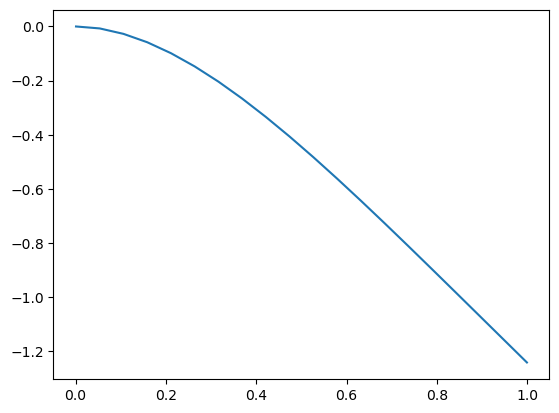

In [28]:
# plot it
plt.plot(liste_x, liste_y)

## 12) We compare this u_y value to linear beam theory
$$H(x_1)=?= u_{y,fenicsX}(x_1,0)$$

$$ H(x_1) = H_\text{max} \, \left ( - \frac{1}{3} \, (x_1-1)^4 - \frac{4}{3} \, x_1 + \frac{1}{3} \right) $$

In [29]:
# we introduce the coefficients
D = E*d**3/12./(1.-nu**2) # bending rigidity of an elastic plate
k = - extract.solution(my_domain, u_solution, 1, 0)[1] * D /(g*d)
Hmax = k*g*d/D # maximum vertical deflection, from linear 'beam' theory 

In [30]:
Hmax

1.2422247416754928

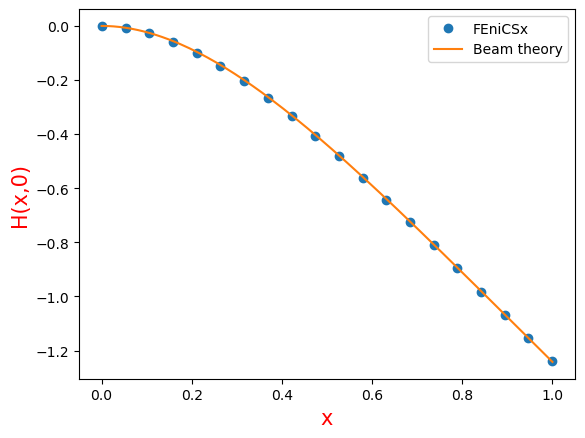

In [31]:
x = np.linspace(0., L, num=150)

plt.plot(liste_x, liste_y, "o", linewidth=2, label="FEniCSx")

H_formula = Hmax * (-1./3.*(x-1.)**4 - 4./3.*x + 1/3)
plt.plot(x, H_formula, label='Beam theory')
plt.xlabel('x',color='red',fontsize=15)
plt.ylabel('H(x,0)',color='red',fontsize=15)
plt.legend()

## Does this work, why ?

## 14) Using PVista

In [32]:
import pyvista
pyvista.set_jupyter_backend("none")
pyvista.start_xvfb()

In [33]:
# Create pyvista grid
topology, cell_types, geometry = dolfinx.plot.create_vtk_mesh(V)
grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)

In [34]:
# Create plotter
plotter = pyvista.Plotter()

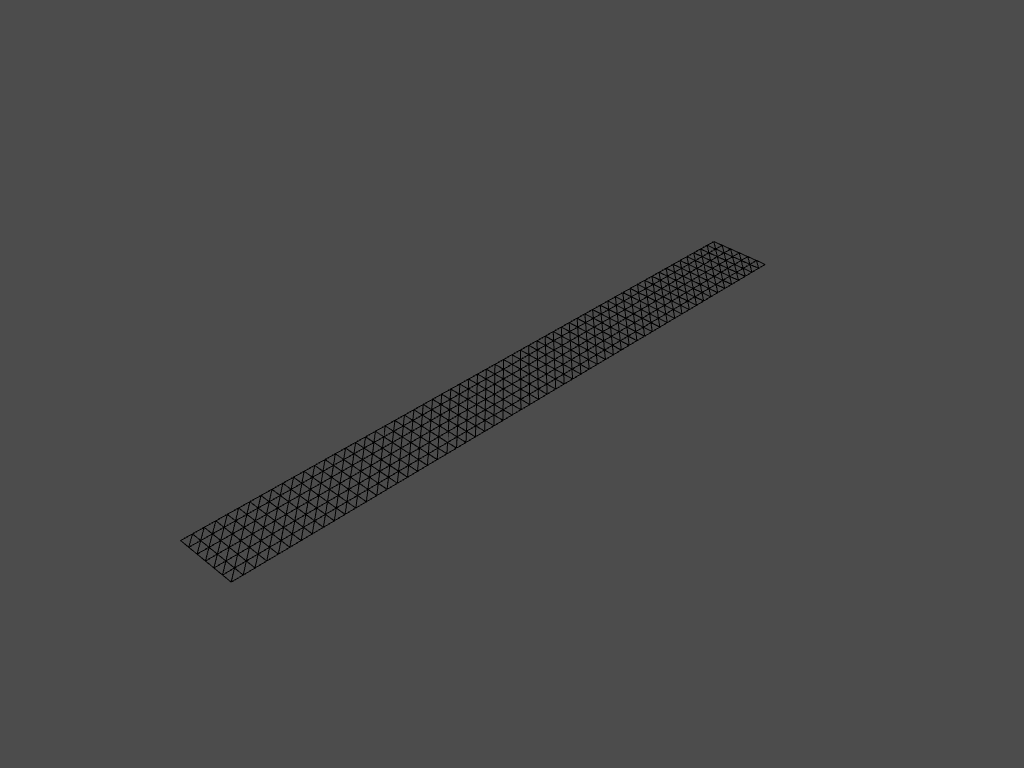

In [35]:
# we first add the grid
plotter.add_mesh(grid, show_edges=True, style="wireframe", color="k");
# Then we display the scene
plotter.show()

```
Can you add the solution ?
```

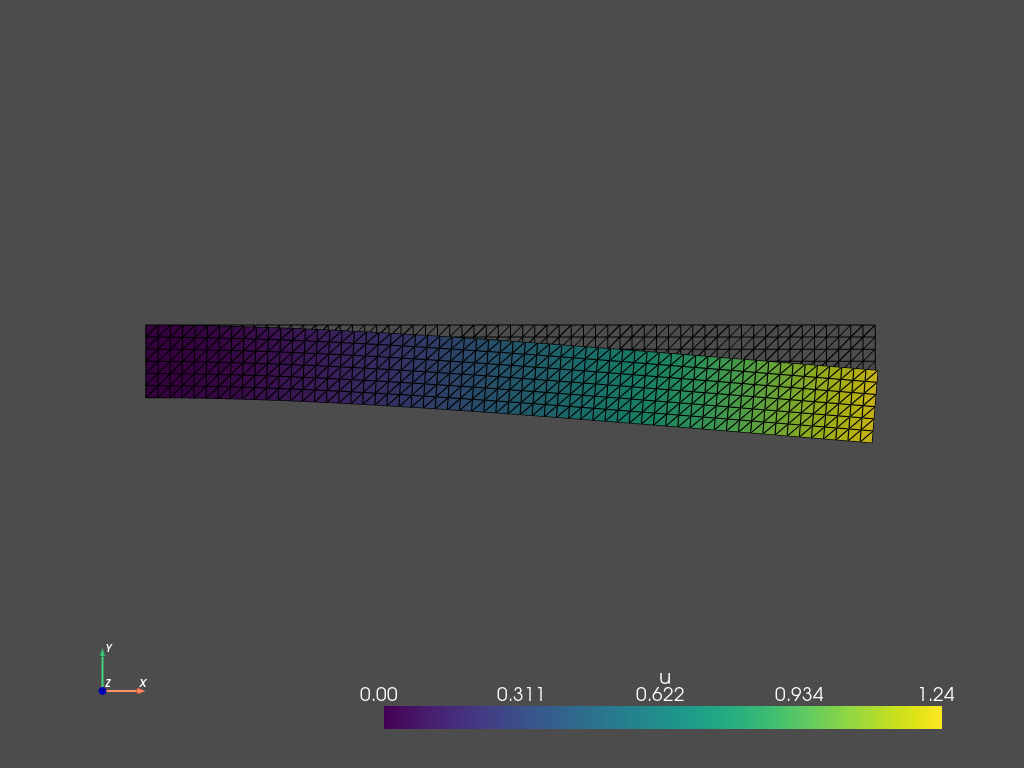

In [36]:
plotter2 = pyvista.Plotter()

grid["u"] = u_solution.x.array.reshape((geometry.shape[0], 2))
new_grid = np.append(grid["u"], np.zeros((grid["u"].shape[0], 1)), axis=1)
grid["u"] = new_grid
actor_0 = plotter2.add_mesh(grid, style="wireframe", color="k")
warped = grid.warp_by_vector("u", factor=0.05)
plotter2.add_mesh(warped, show_edges=True);
plotter2.show_axes()
plotter2.view_xy()
plotter2.show()